<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/D3_CNN9_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import numpy as np
import cv2
import keras
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.applications.efficientnet import EfficientNetB0
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
def preprocess_image(image_path):
    # Read grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize image to (224, 224)
    image = cv2.resize(image, (255, 255))
    # Convert grayscale to RGB by stacking the single channel
    image_rgb = np.stack((image,) * 3, axis=-1)
    return image_rgb

In [4]:
from google.colab import drive

drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/Dataset/Dataset2/AGEDB_dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: AgeDB/5500_MichaelKeaton_49_m.jpg  
  inflating: AgeDB/5501_MichaelKeaton_50_m.jpg  
  inflating: AgeDB/5502_MichaelKeaton_51_m.jpg  
  inflating: AgeDB/5503_MichaelKeaton_52_m.jpg  
  inflating: AgeDB/5504_MichaelKeaton_53_m.jpg  
  inflating: AgeDB/5505_MichaelKeaton_55_m.jpg  
  inflating: AgeDB/5506_MichaelKeaton_58_m.jpg  
  inflating: AgeDB/5507_MichaelKeaton_59_m.jpg  
  inflating: AgeDB/5508_MichaelKeaton_60_m.jpg  
  inflating: AgeDB/5509_MichaelKeaton_61_m.jpg  
  inflating: AgeDB/550_angelamerkel_51_f.jpg  
  inflating: AgeDB/5510_MichaelKeaton_62_m.jpg  
  inflating: AgeDB/5511_MichaelKeaton_63_m.jpg  
  inflating: AgeDB/5512_MichaelKeaton_64_m.jpg  
  inflating: AgeDB/5513_MichaelKeaton_65_m.jpg  
  inflating: AgeDB/5514_NicolasSarkozy_20_m.jpg  
  inflating: AgeDB/5515_NicolasSarkozy_21_m.jpg  
  inflating: AgeDB/5516_NicolasSarkozy_23_m.jpg  
  inflating: AgeDB/5517_NicolasSarkozy_25_m.jpg  
  inflating: Age

In [5]:
# Define age ranges
age_ranges = [(1, 2), (3, 9), (10, 20), (21, 27), (28, 45), (46, 65), (66, 116)]

# Function to map age to range index
def age_to_range(age, age_ranges):
    for idx, (start, end) in enumerate(age_ranges):
        if start <= age <= end:
            return idx
    return 0

In [6]:
def preprocess_labels(labels, num_classes):
    # One-hot encode labels
    labels = to_categorical(labels, num_classes=num_classes)
    return labels

In [14]:
# Load and preprocess the dataset
image_dir = '/content/AgeDB'
images=[]
image_paths = []
age_labels = []
age_groups = []
target_size = (224, 224)

for filename in os.listdir(image_dir):
   if filename.endswith(".jpg"):
    age = int(filename.split('_')[2])
    range_index = age_to_range(age, age_ranges)
    age_labels.append(range_index)

    image_path = os.path.join(image_dir, filename)
    image = preprocess_image(image_path)
    images.append(image)
    image_paths.append(image_path)

images = np.array(images)
age_groups = age_labels
age_labels = preprocess_labels(age_labels, len(age_ranges))

In [15]:
# Print shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {age_labels.shape}")

Images shape: (16488, 255, 255, 3)
Labels shape: (16488, 7)


In [16]:
def age_group_to_interval(group_index):
    if group_index < 0 or group_index >= len(age_ranges):
        return "Unknown"

    start, end = age_ranges[group_index]
    return f"{start}-{end}"

In [17]:
import pandas as pd
df = pd.DataFrame()
age_intervals = [age_group_to_interval(age) for age in age_groups]
df['images_path'],df['age'] = image_paths,age_intervals
df.head(10)

,images_path,age
0,/content/AgeDB/2451_ChevyChase_42_m.jpg,28-45
1,/content/AgeDB/378_DavidSarnoff_48_m.jpg,46-65
2,/content/AgeDB/12185_GlendaJackson_36_f.jpg,28-45
3,/content/AgeDB/13712_NormaShearer_39_f.jpg,28-45
4,/content/AgeDB/12074_ElsaMartinelli_59_f.jpg,46-65
5,/content/AgeDB/15690_KathrynGrayson_62_f.jpg,46-65
6,/content/AgeDB/15063_BettyGarrett_64_f.jpg,46-65
7,/content/AgeDB/10264_LivUllmann_66_f.jpg,66-116
8,/content/AgeDB/997_CarlSagan_50_m.jpg,46-65
9,/content/AgeDB/118_MickJagger_50_m.jpg,46-65


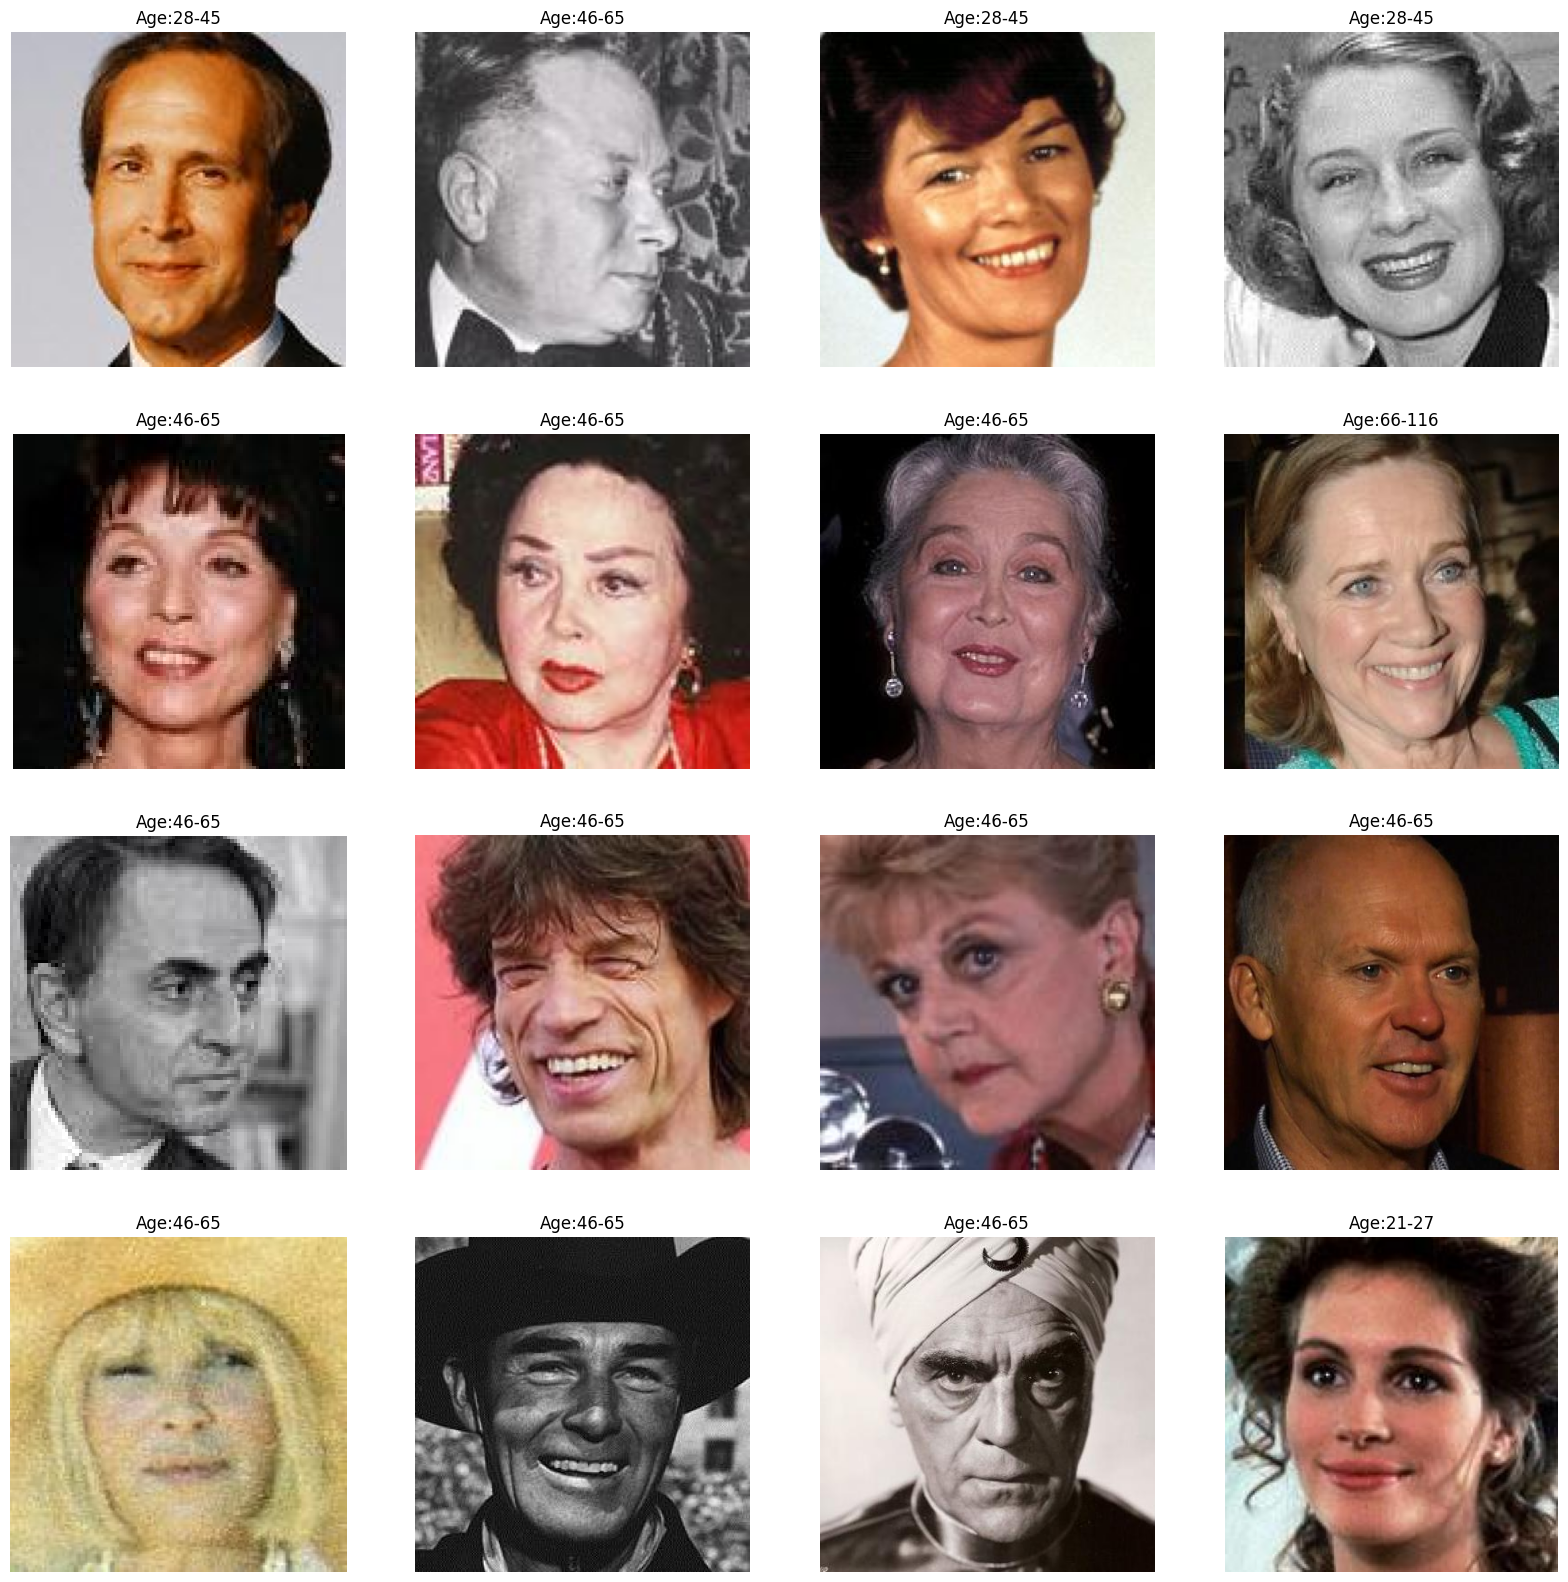

In [18]:
plt.figure(figsize=(20,20))
samples = df.iloc[0:16]

for index,sample,age in samples.itertuples():
  plt.subplot(4,4,index+1)
  img = load_img(sample)
  img = np.array(img)
  plt.axis('off')
  plt.title(f'Age:{age}')
  plt.imshow(img)

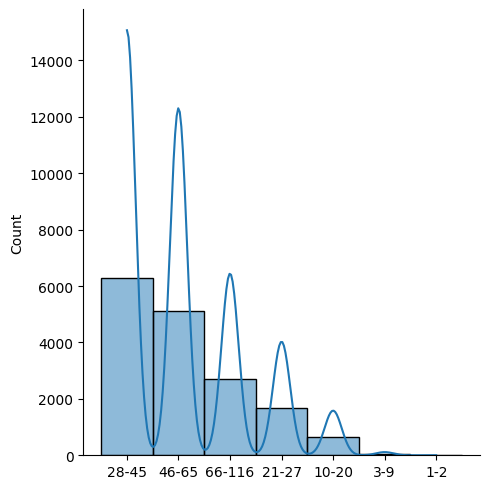

In [19]:
#age distribution
sns.displot(data=age_intervals,kde=True)

In [20]:
train_images, test_images, train_age_groups, test_age_groups = train_test_split(images, age_labels, test_size=0.3, random_state=42)


In [21]:
# Load the pre-trained ResNet50 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(255, 255, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(132, activation='relu')(x)
predictions = Dense(len(age_ranges), activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


16705208/16705208 [==============================] - 0s 0us/step


In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dataset/Dataset2/model-weights/D3_CNN9_A3.h5',  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,
    save_best_only=True,  # Only save the best model
    mode='max'  # Mode to determine best (maximizing validation accuracy)
)


In [23]:
model.fit(train_images, train_age_groups, validation_split=0.2, epochs=60, batch_size=32, callbacks=[early_stopping, model_checkpoint], shuffle=False)


Epoch 1/60
289/289 [==============================] - ETA: 0s - loss: 1.1761 - accuracy: 0.5135
Epoch 1: val_accuracy improved from -inf to 0.54829, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D3_CNN9_A3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


289/289 [==============================] - 110s 242ms/step - loss: 1.1761 - accuracy: 0.5135 - val_loss: 1.0429 - val_accuracy: 0.5483
Epoch 2/60
289/289 [==============================] - ETA: 0s - loss: 0.8396 - accuracy: 0.6436
Epoch 2: val_accuracy improved from 0.54829 to 0.58597, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D3_CNN9_A3.h5
289/289 [==============================] - 69s 240ms/step - loss: 0.8396 - accuracy: 0.6436 - val_loss: 0.9714 - val_accuracy: 0.5860
Epoch 3/60
289/289 [==============================] - ETA: 0s - loss: 0.6208 - accuracy: 0.7538
Epoch 3: val_accuracy improved from 0.58597 to 0.58770, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D3_CNN9_A3.h5
289/289 [==============================] - 69s 239ms/step - loss: 0.6208 - accuracy: 0.7538 - val_loss: 1.0904 - val_accuracy: 0.5877
Epoch 4/60
289/289 [==============================] - ETA: 0s - loss: 0.4141 - accuracy: 0.8467
Epoch 4: val_accuracy did not

In [24]:
# Load the best model
model.load_weights('/content/drive/MyDrive/Dataset/Dataset2/model-weights/D3_CNN9_A3.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_age_groups)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


155/155 [==============================] - 7s 47ms/step - loss: 1.8840 - accuracy: 0.5864
Test Accuracy: 58.64%


In [25]:

predictions = model.predict(test_images)

# Convert predictions to class labels if needed
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_age_groups, axis=1)

155/155 [==============================] - 8s 44ms/step


In [26]:
# Example metrics calculation
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        14
           2       0.30      0.19      0.24       195
           3       0.33      0.25      0.28       516
           4       0.59      0.73      0.65      1810
           5       0.61      0.58      0.60      1568
           6       0.74      0.58      0.65       844

    accuracy                           0.59      4947
   macro avg       0.43      0.39      0.40      4947
weighted avg       0.58      0.59      0.58      4947



In [27]:
# Calculate classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.59
Precision: 0.58
Recall: 0.59
F1-score: 0.58


In [28]:
# Calculate accuracy for each class
class_accuracies = {}
for idx, (start, end) in enumerate(age_ranges):
    # Filter predictions and true labels for the current class
    mask = (true_classes == idx)
    accuracy = accuracy_score(true_classes[mask], predicted_classes[mask])
    class_accuracies[f'{start}-{end}'] = accuracy

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [29]:
# Print accuracy for each class
for age_range, accuracy in class_accuracies.items():
    print(f'Accuracy for age range {age_range}: {accuracy:.2f}')

Accuracy for age range 1-2: nan
Accuracy for age range 3-9: 0.00
Accuracy for age range 10-20: 0.19
Accuracy for age range 21-27: 0.25
Accuracy for age range 28-45: 0.73
Accuracy for age range 46-65: 0.58
Accuracy for age range 66-116: 0.58


In [31]:

# Confusion Matrix
print('\nConfusion Matrix:')
print(confusion_matrix(true_classes, predicted_classes))


Confusion Matrix:
[[   0    8    3    3    0    0]
 [   0   38   67   84    5    1]
 [   1   32  128  339   15    1]
 [   0   36  171 1330  267    6]
 [   1   11   14  459  914  169]
 [   0    0    1   50  302  491]]
